# Intro to cpadapter

This notebooks shows an example `cpadapter`. This package adapts scikit learn, lightgbm, catboost and xgboost models in order to create confidence intervals using conformal prediction (using the nonconformist package internally). After a model has been adapted it can be fitted and calibrated, to, ultimately, predict the target values and their confidence interval.

Also, it provides performance measures and visualization functions for regression and classification cases

First, we have to import the packages we need, including cpadapter. To use this package we need  `lightgbm >= 3.1`

In [7]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgbm
import pandas as pd
import numpy as np
import sys
sys.path.append("../")
import cpadapter
from cpadapter.utils import train_cal_test_split

## Regression

### Load data

For the regression example we use a dataset of health insurance charges (check https://www.kaggle.com/teertha/ushealthinsurancedataset)

This dataset has 6 feature columns and a target column named `charges`. 

In [23]:
path = "https://gist.githubusercontent.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41/raw/d42d226d0dd64e7f5395a0eec1b9190a10edbc03/Medical_Cost.csv"
categorical_columns = ['sex', 'smoker', 'region']

df_raw = pd.read_csv(path, dtype={cat: 'category' for cat in categorical_columns})

for col in categorical_columns:
    df_raw[col] = df_raw[col].cat.codes

df_raw.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,3,16884.9240
1,18,1,33.77,1,0,2,1725.5523
2,28,1,33.00,3,0,2,4449.4620


Now that we have loaded the data and all the features are ints or floats, we can use the `train_cal_test_split` fuction to split the data, making it compatible with the cpadapter package.

In [24]:
x_train, y_train, x_cal, y_cal, x_test, y_test = train_cal_test_split(df_raw, 'charges', 0.7, 0.2, True)

### Creating the confidence intervals

Since we have the training, calibration and test data ready, we can adapt different models in order to perform conformal prediction, and generate confidence intervals.

In this example we are going to adapt a RandomForestRegressor, a model that belongs to the Scikit Learn package, meaning the `sklearn_model` input variable must be set to `True`.

In [25]:
model = RandomForestRegressor(n_estimators=100)
cp_model = cpadapter.Adapt_to_CP(model, True)

The adaped model must be fitted and calibrated. After this we can produce predictions of the target values and the confidence interval 

In [10]:
confidence = 0.8 #@param
cp_model.fit(x_train, y_train)
cp_model.calibrate(x_cal, y_cal)
prediction = cp_model.predict(x_test, confidence)
# Alternatively, we can use the one-liner 
# prediction = cp_model.calibrate_and_predict(x_cal, y_cal, x_test, confidence)

In this case (regression) the predict method returns 3 elements: the lower bound , the target predictions and the upper bound.

In [11]:
lower, pred_target, upper = prediction

### Performance measures

To measure the performance of the predicted interval in regression cases the package provides 4 functions

In [21]:
from cpadapter.performance_measures import picp, pinaw, relative_width, relative_mean_width
coverage = picp(y_test, lower, upper)
norm_width = pinaw(y_test, lower, upper)
rel_width = relative_width(y_test, lower, upper)
rel_mean_width = relative_mean_width(y_test, lower, upper)

print('Interval coverage: ', coverage)
print('Interval normalized width: ', norm_width)
print('Median relative width: ', rel_width)
print('Average width relative to the mean target value: ', rel_mean_width)

Interval coverage:  0.8888888888888888
Interval normalized width:  0.2225407826777561
Median relative width:  1.0892693507764326
Average width relative to the mean target value:  0.8350769336811872


The measure provided by the picp fuction gives the empirical coverage of the predicted interval. On the other hand, the other numeric mesures let us know how wide or narrow is the predicted interval relative to the target range, the target values and the mean target value.

In this case the interval surpasses the confidence level we set when creating the interval (0.8).

### Visualizations

The package also provides 3 visualization functions for confidence intervals created for regression data.

In [14]:
from cpadapter.visualization import band_interval_plot, conditional_band_interval_plot, line_interval_plot

Each one of this functions has a boolean input named `sort`. This variable defines if the data should be sorted ascendingly or not.

For tabular data the recomendation is to set `sort = True` and for time series is to set `sort = False`

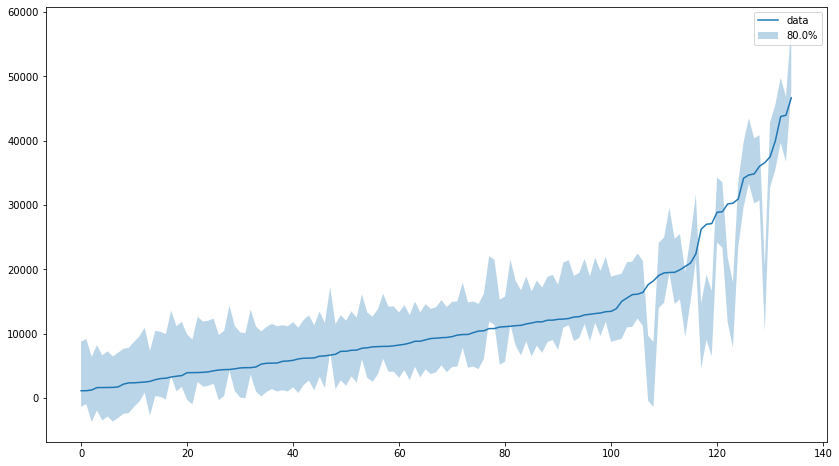

In [18]:
sort =  True#@param
band_interval_plot(y_test, lower, upper, confidence, sort)

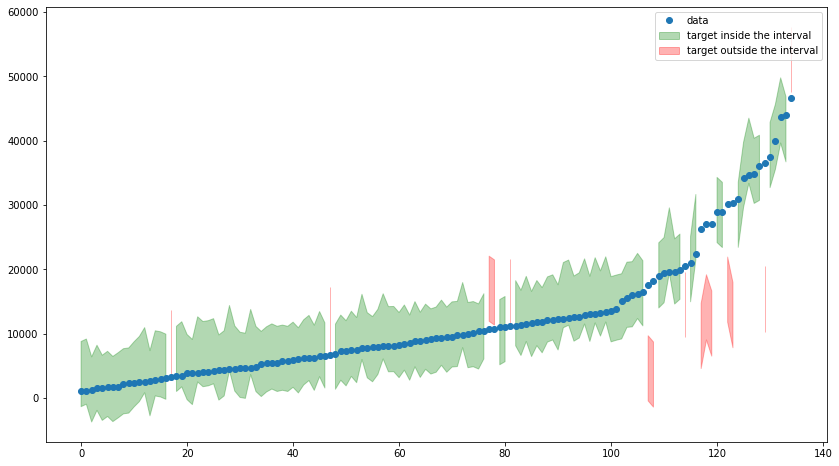

In [19]:
sort =  True#@param
conditional_band_interval_plot(y_test, lower, upper, sort)

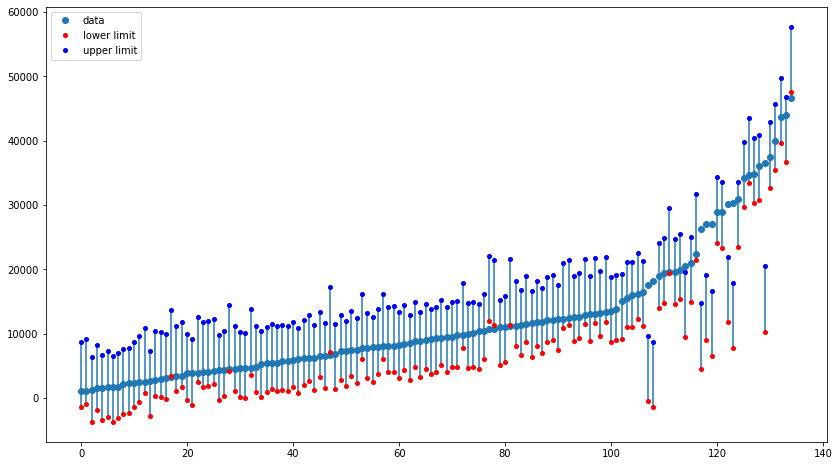

In [20]:
sort =  True#@param
line_interval_plot(y_test, lower, upper, sort)

## Classification

### Load data

For this example we are going to use a dataset of Spotify songs that we want to classify according to their genre. The dataset has 13 feature columns and 1 target column named `genre`. The target columns has the name of the genre, so first, we have to turn this feature to a numeric variable. 

In [96]:
path = "/content/drive/My Drive/Práctica 2/genres_v2.csv"
df_raw = pd.read_csv(path)
df_raw.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title'], inplace=True)

genres = []
genre = []
classes = []
c = 0
for i in range(df_raw.shape[0]):
    g = df_raw['genre'][i]
    if not g in genres:
        genres.append(g)
        classes.append(c)
        genre.append(c)
        c += 1
    else:
        idx = genres.index(g)
        genre.append(classes[idx])

genre = np.array(genre)
df_raw['genre'] = genre.astype(int)
df_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,124539,4,0
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,224427,4,0
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,98821,4,0
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,123661,3,0
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,123298,4,0


In [97]:
x_train, y_train, x_cal, y_cal, x_test, y_test = train_cal_test_split(df_raw, 'genre', 0.7, 0.2, True)

### Creating the confidence intervals

In this case, we are going to use a model from lightgbm, this means the input variable `sklearn_model` given to the Adapt_to_CP class must be `False` 

In [98]:
model = lgbm.LGBMClassifier()
cp_model = cpadapter.Adapt_to_CP(model, False)

In [99]:
cp_model.fit(x_train, y_train)
cp_model.calibrate(x_cal, y_cal)

confidence = 0.8 #@param
prediction = cp_model.predict(x_test, confidence)

In this case the prediction has 2 elements: the fist one being the confidence interval and the second one the class prediction.

In [80]:
interval = prediction[0]
pred_class = prediction[1]

### Performance measures

Just like in the regression example, the package provides fuctions that return performance measures for the predicted interval.

In [81]:
from cpadapter.performance_measures import right_guess, width, uncertainty

In [82]:
coverage = right_guess(y_test, interval)
uncertain_cases = uncertainty(interval)
norm_width = width(interval)

In [83]:
print('Interval coverage: ', coverage)
print('Interval normalized width: ', norm_width)
print('Percentage of uncertain predicted intervals: ', uncertain_cases)

Interval coverage:  0.7962656582368235
Interval normalized width:  0.10471913653194674
Percentage of uncertain predicted intervals:  0.00590876861262113


The `right_guess` measure gives us the fraction of times the predicted confidence interval contains the real class, the function `width` returns the normalized interval width and `uncertainty` returns the faction of times the predicted interval contains all the possible classes.

In this case the coverage is near 80% (level of confidence we used for creating the interval), the average interval width is 0.1047*15=1.5705 (normalized width * number of possible classes) and only a 0.59% of the times the interval created is "uncertain".

### Visualizations

The package also provides 3 visualization functions for classification cases

In [85]:
from cpadapter.visualization import plot_class_interval, class_histogram, confusion_matrix

The first visualization function shows the classes conforming the predicted interval and the classes in the `y` array (predicted or real test target classes). This plot is only useful when dealing with a small number of observations.

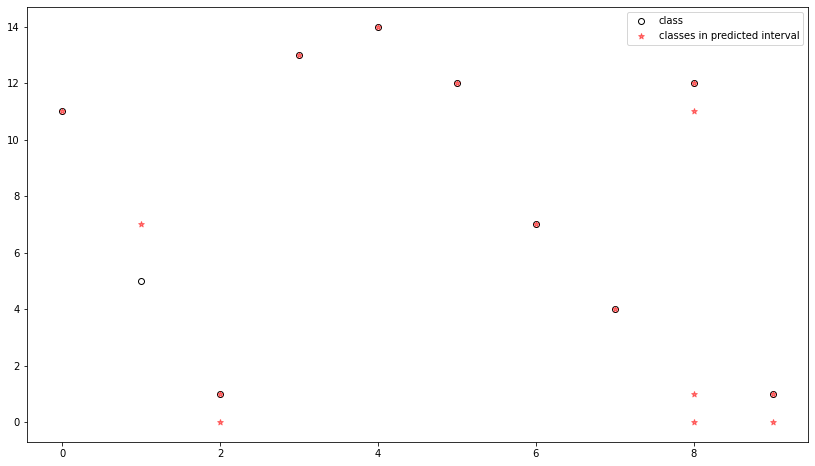

In [86]:
plot_class_interval(y_test[10:20], interval[10:20])

As we can see, when the actual class overlaps with one of the classes in the interval, the white dot turns red.

Then, with the `class_histogram` function we can plot the histogram for the classes in the `y` array and the classes inside the predicted intervals. This helps us see which classes are more present in the predicted intervals. On the other hand, we can check if a class is repeted more times in `y` than it is in the intervals.

/usr/local/lib/python3.7/dist-packages/cpadapter/visualization.py:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pred_classes = np.array(classes_in_interval(preds))


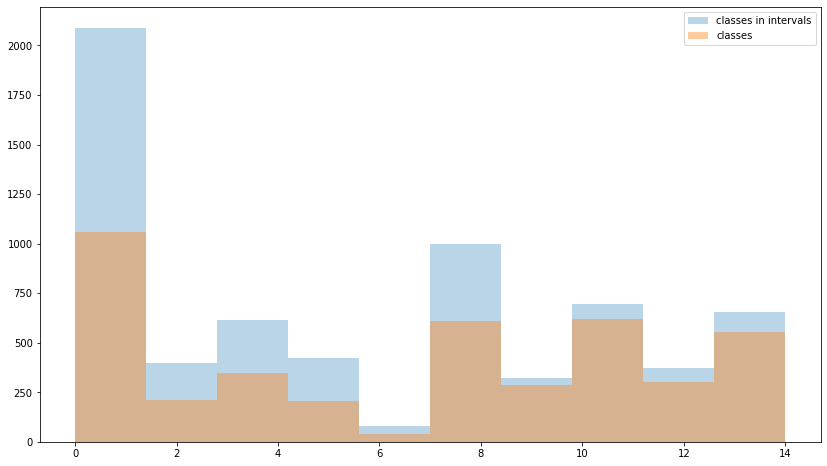

In [87]:
class_histogram(y_test, interval)

Lastly, the `confusion_matrix` fuction shows the confusion matrix for the real classes in `y` and the classes in the predicted intervals. In this case the numbers inside the matrix represent the fraction of times a certain class (x axis) is present in the confidence interval, when the real class was the one on the y axis.

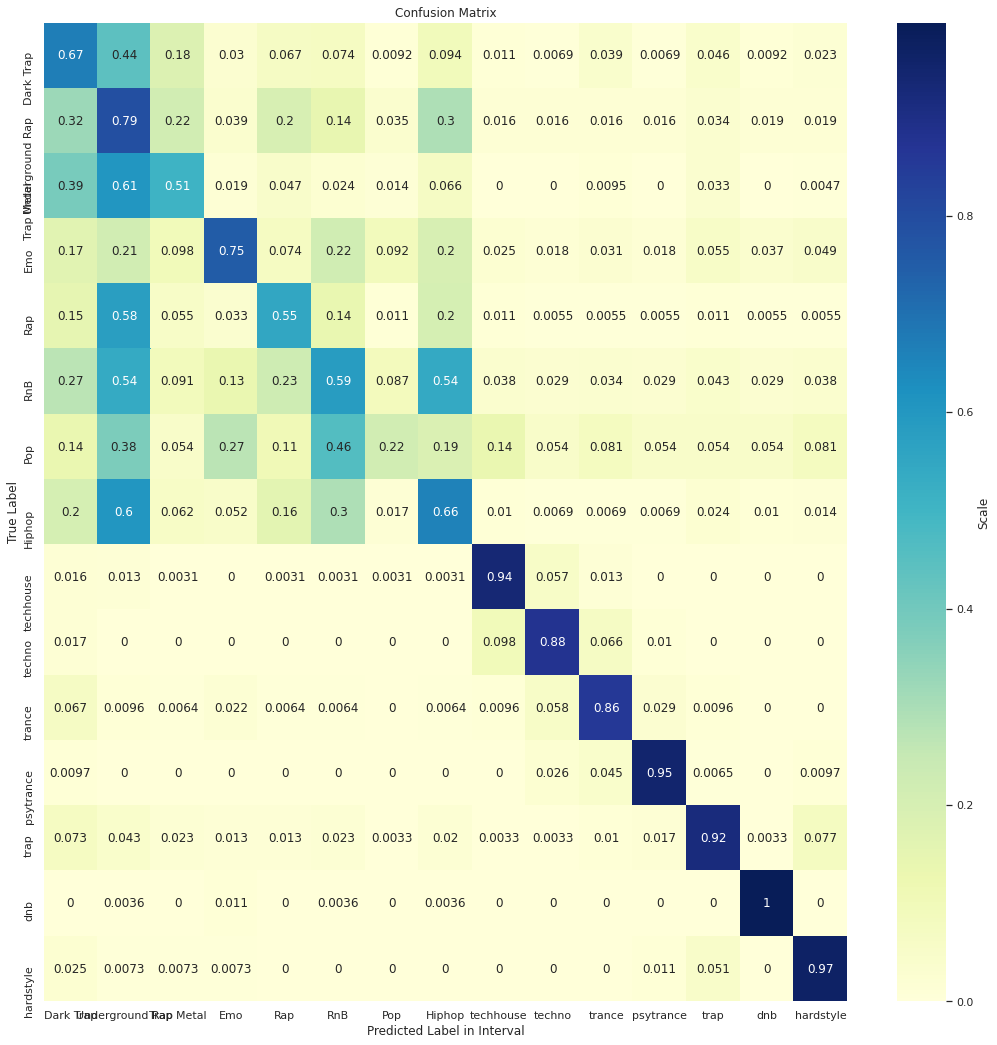

In [88]:
confusion_matrix(y_test, interval, genres)